In [1]:
import os

from monai.data   import DataLoader, Dataset, CacheDataset
from sklearn.model_selection import train_test_split
from monai.config import print_config, USE_COMPILED
from monai.utils import set_determinism, first
from monai.networks.nets import GlobalNet
from monai.networks.blocks import Warp
from monai.apps import MedNISTDataset
import matplotlib.pyplot as plt
from torch.nn import MSELoss
from monai import transforms
import numpy as np
import torch

print_config()
set_determinism(99)

/opt/conda/envs/ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/ml/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


MONAI version: 1.2.0
Numpy version: 1.25.2
Pytorch version: 1.13.1.post200
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: /opt/conda/envs/ml/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.12
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: 0.21.0
Pillow version: 9.4.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.14.1
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.0.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.32.0
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://doc

In [2]:
SEP       = os.path.sep
ROOT_PATH = SEP.join(os.getcwd().split(SEP)[:-4])
DATA_PATH = f'{ROOT_PATH}/Datasets/MedNIST'

os.makedirs(DATA_PATH, exist_ok = True)

In [3]:
train_data     = MedNISTDataset(DATA_PATH, section = 'training', 
                                download = True, transform=None)

## 손 x-ray 데이터 셋을 이용한 image registration
train_datadict = [{'fixed_hand' : item['image'], 'moving_hand' : item['image']}
                  for item in train_data.data if item['label'] == 4]

print(f'sample datas \n{train_datadict[:3]}')

2023-08-29 00:06:44,240 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2023-08-29 00:06:44,241 - INFO - File exists: /home/jovyan/dove/projects/BACKUP/TIL/Datasets/MedNIST/MedNIST.tar.gz, skipped downloading.
2023-08-29 00:06:44,241 - INFO - Non-empty folder exists in /home/jovyan/dove/projects/BACKUP/TIL/Datasets/MedNIST/MedNIST, skipped extracting.


Loading dataset: 100%|██████████| 47164/47164 [00:00<00:00, 149045.70it/s]

sample datas 
[{'fixed_hand': '/home/jovyan/dove/projects/BACKUP/TIL/Datasets/MedNIST/MedNIST/Hand/005758.jpeg', 'moving_hand': '/home/jovyan/dove/projects/BACKUP/TIL/Datasets/MedNIST/MedNIST/Hand/005758.jpeg'}, {'fixed_hand': '/home/jovyan/dove/projects/BACKUP/TIL/Datasets/MedNIST/MedNIST/Hand/007758.jpeg', 'moving_hand': '/home/jovyan/dove/projects/BACKUP/TIL/Datasets/MedNIST/MedNIST/Hand/007758.jpeg'}, {'fixed_hand': '/home/jovyan/dove/projects/BACKUP/TIL/Datasets/MedNIST/MedNIST/Hand/001798.jpeg', 'moving_hand': '/home/jovyan/dove/projects/BACKUP/TIL/Datasets/MedNIST/MedNIST/Hand/001798.jpeg'}]


In [4]:
train_transforms = transforms.Compose(
    [
        transforms.LoadImageD(keys=["fixed_hand", "moving_hand"]),
        transforms.EnsureChannelFirstD(keys=["fixed_hand", "moving_hand"]),
        transforms.ScaleIntensityRanged(
            keys=["fixed_hand", "moving_hand"],
            a_min=0.0,
            a_max=255.0,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        transforms.RandRotateD(keys=["moving_hand"], range_x=np.pi / 4, prob=1.0, keep_size=True, mode="bicubic"),
        transforms.RandZoomD(keys=["moving_hand"], min_zoom=0.9, max_zoom=1.1, prob=1.0, mode="bicubic", align_corners=False),
    ])

/opt/conda/envs/ml/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


In [5]:
check_ds     = Dataset(data = train_datadict, transform = train_transforms)
check_loader = DataLoader(check_ds, batch_size = 1, shuffle = True)
check_data   = first(check_loader)
fixed_image  = check_data['fixed_hand'][0][0]
moving_image = check_data['moving_hand'][0][0]

print(f'moving image shape : {moving_image.shape}')
print(f'fixed  image shape : {fixed_image.shape}')

moving image shape : torch.Size([64, 64])
fixed  image shape : torch.Size([64, 64])


In [6]:
train, valid = train_test_split(train_datadict, test_size = 0.2, shuffle = True,
                                random_state = 99)

len(train), len(valid)

(6399, 1600)

In [7]:
train_ds     = CacheDataset(data = train, transform = train_transforms)
valid_ds     = CacheDataset(data = valid, transform = train_transforms)

train_loader = DataLoader(train_ds, batch_size = 16, shuffle =  True, num_workers = 2) 
valid_loader = DataLoader(valid_ds, batch_size = 16, shuffle = False, num_workers = 2) 

Loading dataset: 100%|██████████| 1600/1600 [00:01<00:00, 908.12it/s]


In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model  = GlobalNet(image_size = (64, 64), spatial_dims = 2, in_channels = 2,
                   num_channel_initial = 16, depth=3).to(device)

image_loss = MSELoss()
if USE_COMPILED: warp_layer = Warp(3, 'border').to(device)
else: warp_layer = Warp('bilinear', 'border').to(device)

optimizer = torch.optim.Adam(model.parameters(), 1e-5)

/opt/conda/envs/ml/lib/python3.10/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/opt/conda/envs/ml/lib/python3.10/site-packages/monai/networks/blocks/warp.py:67: UserWarning: monai.networks.blocks.Warp: Using PyTorch native grid_sample.
  warnings.warn("monai.networks.blocks.Warp: Using PyTorch native grid_sample.")


In [9]:
def train(model, loader, optimizer, loss_func):
    model.train()
    
    loss = 0
    for batch in loader:

        optimizer.zero_grad()
        
        moving     = batch['moving_hand'].to(device)
        fixed      = batch['fixed_hand'].to(device)
        ddf        = model(torch.cat((moving, fixed), dim = 1))
        pred_image = warp_layer(moving, ddf)
        
        loss_      = loss_func(pred_image, fixed)
        loss_.backward()
        
        optimizer.step()
        loss += loss_.item()
        
    loss /= len(loader.dataset)
    return loss


def validation(model, loader, loss_function):
    
    model.eval()
    loss = 0
    
    with torch.no_grad():
        for batch in loader:
            
            moving      = batch['moving_hand'].to(device)
            fixed       = batch['fixed_hand'].to(device)
            
            ddf         = model(torch.cat((moving, fixed), dim = 1))
            pred_image  = warp_layer(moving, ddf)
            
            loss_       = loss_function(pred_image, fixed)
            loss       += loss_.item()
    
    loss /= len(loader.dataset)
    return loss        

In [10]:
epochs       = 100
train_losses = []
valid_losses = []

for epoch in range(1, epochs + 1):
    
    print(f'[{epoch} / {epochs}]')
    train_loss = train(model, train_loader, optimizer, image_loss)
    valid_loss = validation(model, valid_loader, image_loss)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'epoch {epoch} train avg loss : {train_loss:.3f}, valid avg loss : {valid_loss:.3f}')

[1 / 100]
epoch 1 train avg loss : 0.003, valid avg loss : 0.003
[2 / 100]
epoch 2 train avg loss : 0.002, valid avg loss : 0.002
[3 / 100]
epoch 3 train avg loss : 0.002, valid avg loss : 0.002
[4 / 100]
epoch 4 train avg loss : 0.002, valid avg loss : 0.002
[5 / 100]
epoch 5 train avg loss : 0.001, valid avg loss : 0.001
[6 / 100]
epoch 6 train avg loss : 0.001, valid avg loss : 0.001
[7 / 100]
epoch 7 train avg loss : 0.001, valid avg loss : 0.001
[8 / 100]
epoch 8 train avg loss : 0.001, valid avg loss : 0.001
[9 / 100]
epoch 9 train avg loss : 0.001, valid avg loss : 0.001
[10 / 100]
epoch 10 train avg loss : 0.001, valid avg loss : 0.001
[11 / 100]
epoch 11 train avg loss : 0.001, valid avg loss : 0.001
[12 / 100]
epoch 12 train avg loss : 0.001, valid avg loss : 0.001
[13 / 100]
epoch 13 train avg loss : 0.001, valid avg loss : 0.001
[14 / 100]
epoch 14 train avg loss : 0.001, valid avg loss : 0.001
[15 / 100]
epoch 15 train avg loss : 0.001, valid avg loss : 0.001
[16 / 100]
ep

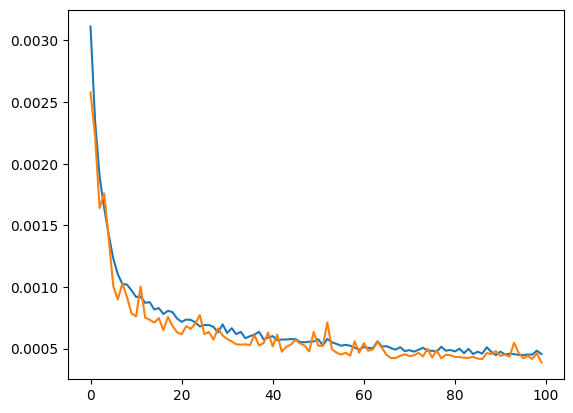

In [11]:
plt.plot(range(epochs), train_losses, label = 'train')
plt.plot(range(epochs), valid_losses, label = 'valid')

In [12]:
test_data     = MedNISTDataset(DATA_PATH, section = 'test', 
                                download = True, transform=None)

## 손 x-ray 데이터 셋을 이용한 image registration
test_datadict = [{'fixed_hand' : item['image'], 'moving_hand' : item['image']}
                  for item in test_data.data if item['label'] == 4]

2023-08-29 00:47:04,579 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2023-08-29 00:47:04,579 - INFO - File exists: /home/jovyan/dove/projects/BACKUP/TIL/Datasets/MedNIST/MedNIST.tar.gz, skipped downloading.
2023-08-29 00:47:04,580 - INFO - Non-empty folder exists in /home/jovyan/dove/projects/BACKUP/TIL/Datasets/MedNIST/MedNIST, skipped extracting.


Loading dataset: 100%|██████████| 5895/5895 [00:00<00:00, 1108266.34it/s]


In [13]:
test_ds     = CacheDataset(data = test_datadict, transform = train_transforms)
test_loader = DataLoader(test_ds, batch_size = 1, shuffle =  False, num_workers = 2) 

Loading dataset: 100%|██████████| 996/996 [00:01<00:00, 733.76it/s]


In [14]:
for batch in test_loader:
    
    moving     = batch['moving_hand'].to(device)
    fixed      = batch['fixed_hand'].to(device)
    ddf        = model(torch.cat((moving, fixed), dim = 1))
    pred_image = warp_layer(moving, ddf)
    break
    
fixed_image  = fixed.detach().cpu().numpy()[:, 0]
moving_image = moving.detach().cpu().numpy()[:, 0]
pred_image   = pred_image.detach().cpu().numpy()[:, 0]

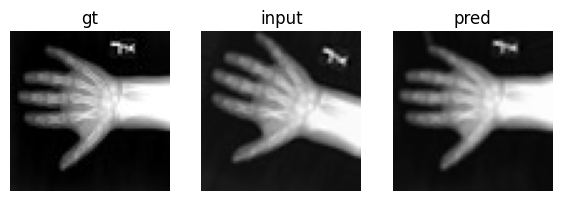

In [15]:
_, axes = plt.subplots(1, 3, figsize = (7, 21))
images   = [fixed_image, moving_image, pred_image]
titles  = ['gt', 'input', 'pred']

for (image, ax, title) in zip(images, axes, titles):
    
    ax.imshow(image.transpose(1, 2, 0), cmap = 'gray')
    ax.axis(False)
    ax.set_title(title)